In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import pygame
import sys
import random
import pickle
import torch
import os
from pyinstrument import Profiler
from torch import nn
from torch.optim import AdamW
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils import clip_grad_norm_

pygame 2.5.2 (SDL 2.28.3, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
profiler = Profiler()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
seed = 567
torch.manual_seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)

cuda:0


## Game class

In [3]:
class BalloonShieldGame:
    def __init__(self, screen_width=1024, screen_height=512):
        pygame.init()
        pygame.display.set_caption("Balloon Shield Game")
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.font = pygame.font.SysFont("Arial", 20)
        self.clock = pygame.time.Clock()
        self.balloon_img = pygame.transform.scale(pygame.image.load("balloon.png"), (60, 60))
        self.shield_img = pygame.transform.scale(pygame.image.load("shield.png"), (60, 80))
        self.bullet_img = pygame.transform.scale(pygame.image.load("bullet.png"), (50, 50))
        self.portal_img = pygame.transform.scale(pygame.image.load("portal.png"), (100, 300))
        self.balloon_pos = (self.screen_width // 2, self.screen_height // 2)
        self.offset = 70

        self.shield_positions = {
            0: ((self.balloon_pos[0] - (self.offset // 2)), (-10 + self.balloon_pos[1] - (self.offset // 2))), # top left
            1: (self.balloon_pos[0], (self.balloon_pos[1] - self.offset)), # top middle
            2: ((self.balloon_pos[0] + (self.offset // 2)) , (-10 + self.balloon_pos[1] - (self.offset // 2))), # top right
            3: ((self.balloon_pos[0] + self.offset), self.balloon_pos[1]), # right middle
            4: ((self.balloon_pos[0] + (self.offset // 2)), (5 + self.balloon_pos[1] + (self.offset // 2))), # bottom right
            5: (self.balloon_pos[0], (self.balloon_pos[1] + self.offset)), # bottom middle
            6: ((self.balloon_pos[0] - (self.offset // 2)) , (5 + self.balloon_pos[1] + (self.offset // 2))),  # bottom left
            7: ((self.balloon_pos[0] - self.offset), self.balloon_pos[1]) # left middle
        }
        self.shield_positions_inverted = {v: k for k, v in self.shield_positions.items()}
        self.shield_images = {
            ((self.balloon_pos[0] - (self.offset // 2)), (-10 + self.balloon_pos[1] - (self.offset // 2))): pygame.transform.rotate(self.shield_img, 315),
            (self.balloon_pos[0], (self.balloon_pos[1] - self.offset)): pygame.transform.rotate(self.shield_img, 90),
            ((self.balloon_pos[0] + (self.offset // 2)) , (-10 + self.balloon_pos[1] - (self.offset // 2))): pygame.transform.rotate(self.shield_img, 45),
            ((self.balloon_pos[0] + self.offset), self.balloon_pos[1]): pygame.transform.rotate(self.shield_img, 0),
            ((self.balloon_pos[0] + (self.offset // 2)), (5 + self.balloon_pos[1] + (self.offset // 2))): pygame.transform.rotate(self.shield_img, 315),
            (self.balloon_pos[0], (self.balloon_pos[1] + self.offset)): pygame.transform.rotate(self.shield_img, 90),
            ((self.balloon_pos[0] - (self.offset // 2)) , (5 + self.balloon_pos[1] + (self.offset // 2))): pygame.transform.rotate(self.shield_img, 45),
            ((self.balloon_pos[0] - self.offset), self.balloon_pos[1]): pygame.transform.rotate(self.shield_img, 0)
        }
        self.shield_pos = self.shield_positions[3]
        self.num_bullets = 10
        self.bullet_radius = 15
        self.bullet_pos = [(random.randint(0, 50), random.randint(0, 50)) for _ in range(self.num_bullets)]
        self.pixel_per_step = (5,5) # at the current impelementation, this is constant.
        self.bullet_directions = []
        for _ in range(len(self.bullet_pos)):
            self.bullet_directions.append(pygame.math.Vector2(random.uniform(-1, 1), random.uniform(-0.9, 0.9)).normalize())

        self.remained_bullets = list(range(self.num_bullets))
        self.state = "going"
        self.episodic = True

        
    def update_game_state(self, action = None):

        if len(self.remained_bullets) == 0:
            print("should not call update_game_state when there are no bullets left")
            sys.exit()
            

        if action is None:
            keys = pygame.key.get_pressed()

            if keys[pygame.K_LEFT]:
                self.shield_pos = self.shield_positions[(self.shield_positions_inverted[self.shield_pos] + 1) % 8]
                self.shield_img = self.shield_images[self.shield_pos]

            elif keys[pygame.K_RIGHT]:
                self.shield_pos = self.shield_positions[(self.shield_positions_inverted[self.shield_pos] - 1) % 8]
                self.shield_img = self.shield_images[self.shield_pos]

            elif keys[pygame.K_ESCAPE]:
                pygame.quit()
                self.state = "exit"
        # One step of the game with action given
        else:
            if action == 0:
                self.shield_pos = self.shield_positions[(self.shield_positions_inverted[self.shield_pos] + 1) % 8]
                self.shield_img = self.shield_images[self.shield_pos]
                #print("left")
            elif action == 1:
                self.shield_pos = self.shield_positions[(self.shield_positions_inverted[self.shield_pos] - 1) % 8]
                self.shield_img = self.shield_images[self.shield_pos]
                #print("right")
                #elif action == 2:
                #print("no press")


        self.shield_rect = pygame.Rect(self.shield_pos[0] - self.shield_img.get_width() // 2, self.shield_pos[1] - self.shield_img.get_height() // 2, self.shield_img.get_width(), self.shield_img.get_height())
        self.obs_rect = pygame.rect.Rect(100, self.screen_height - 80, 650, 30)
        self.balloon_rect = pygame.Rect(self.balloon_pos[0] - self.balloon_img.get_width() // 2, self.balloon_pos[1] - self.balloon_img.get_height() // 2, self.balloon_img.get_width(), self.balloon_img.get_height())
        self.blackhole_pos = (int(self.screen_width - 100), int(self.screen_height - 300))
        self.black_hole_rect = pygame.Rect(self.blackhole_pos[0] + 10, self.blackhole_pos[1] + 50, self.portal_img.get_width() - 20, self.portal_img.get_height() - 100)
        self.blackhole_pos_2 = (100, 0)
        self.black_hole_rect_2 = pygame.Rect(self.blackhole_pos_2[0] + 10, self.blackhole_pos_2[1] + 50, self.portal_img.get_width() - 20, self.portal_img.get_height() - 100)

        for i in self.remained_bullets:

            self.bullet_pos[i] = (self.bullet_pos[i][0] + self.bullet_directions[i].x * self.pixel_per_step[0], self.bullet_pos[i][1] + self.bullet_directions[i].y * self.pixel_per_step[1])
            self.bullet_rect = pygame.Rect(self.bullet_pos[i][0] - self.bullet_radius, self.bullet_pos[i][1] - self.bullet_radius, self.bullet_radius * 2, self.bullet_radius * 2)



            if self.bullet_rect.colliderect(self.black_hole_rect):
                self.pixel_per_step = (5,5)
                if random.randint(0, 1) == 0: # left of the portal
                    self.bullet_pos[i] = (self.blackhole_pos_2[0] - 16 , self.blackhole_pos_2[1] + random.randint(50, 300))
                    self.bullet_directions[i] = pygame.math.Vector2(random.uniform(-1, 0), random.uniform(-0.8, 0.9)).normalize()
                else: # right of the portal
                    self.bullet_pos[i] = (self.blackhole_pos_2[0] + self.portal_img.get_width() + 16 , self.blackhole_pos_2[1] + random.randint(50, 300))
                    self.bullet_directions[i] = pygame.math.Vector2(random.uniform(0, 1), random.uniform(-0.8, 0.9)).normalize()

            elif self.bullet_rect.colliderect(self.black_hole_rect_2):
                self.bullet_pos[i] = (self.blackhole_pos[0] - 16 , self.blackhole_pos[1] + random.randint(50, 300))
                self.pixel_per_step = (5,5)
                self.bullet_directions[i] = pygame.math.Vector2(random.uniform(-1, 0), random.uniform(-0.9, 0.9)).normalize()

            elif self.bullet_rect.colliderect(self.balloon_rect):
                self.state = "hit"
                pygame.quit()
                return

            elif self.bullet_rect.colliderect(self.shield_rect):
                if self.episodic:
                    self.remained_bullets.remove(i)
                    if len(self.remained_bullets) == 0:
                        self.state = "win"
                        pygame.quit()
                        return
                    continue
                else:
                    shield_center = pygame.math.Vector2(self.shield_pos[0], self.shield_pos[1])
                    reflection = self.bullet_directions[i].reflect(shield_center - self.bullet_pos[i])
                    self.bullet_directions[i] = reflection.normalize()

            elif (self.bullet_pos[i][0] <= 0 or self.bullet_pos[i][0] >= self.screen_width):
                self.bullet_pos[i] = (self.bullet_pos[i][0] - self.bullet_directions[i].x * self.pixel_per_step[0], self.bullet_pos[i][1] - self.bullet_directions[i].y * self.pixel_per_step[1])
                self.bullet_rect = pygame.Rect(self.bullet_pos[i][0] - self.bullet_radius, self.bullet_pos[i][1] - self.bullet_radius, self.bullet_radius * 2, self.bullet_radius * 2)
                self.bullet_directions[i].reflect_ip(pygame.math.Vector2(1, 0))
                self.pixel_per_step = (5,5)

            elif (self.bullet_pos[i][1] <= 0 or self.bullet_pos[i][1] >= self.screen_height):
                self.bullet_pos[i] = (self.bullet_pos[i][0] - self.bullet_directions[i].x * self.pixel_per_step[0], self.bullet_pos[i][1] - self.bullet_directions[i].y * self.pixel_per_step[1])
                self.bullet_rect = pygame.Rect(self.bullet_pos[i][0] - self.bullet_radius, self.bullet_pos[i][1] - self.bullet_radius, self.bullet_radius * 2, self.bullet_radius * 2)
                self.bullet_directions[i].reflect_ip(pygame.math.Vector2(0, 1))

            if self.bullet_rect.colliderect(self.obs_rect): 
                self.bullet_pos[i] = (self.bullet_pos[i][0] - self.bullet_directions[i].x *self.pixel_per_step[0], self.bullet_pos[i][1] - self.bullet_directions[i].y *self.pixel_per_step[1])
                self.bullet_rect = pygame.Rect(self.bullet_pos[i][0] - self.bullet_radius, self.bullet_pos[i][1] - self.bullet_radius, self.bullet_radius * 2, self.bullet_radius * 2)
                if self.bullet_pos[i][1] >= self.screen_height - 50:
                    self.bullet_directions[i].reflect_ip(pygame.math.Vector2(0, 1))
                    self.bullet_pos[i] = (self.bullet_pos[i][0], self.bullet_pos[i][1] + 2)
                elif self.bullet_pos[i][1] <= self.screen_height - 80:
                    self.bullet_directions[i].reflect_ip(pygame.math.Vector2(0, 1))
                    self.bullet_pos[i] = (self.bullet_pos[i][0], self.bullet_pos[i][1] - 2)
                elif self.bullet_pos[i][0] <= 100:
                    self.bullet_directions[i].reflect_ip(pygame.math.Vector2(1, 0))
                    self.bullet_pos[i] = (self.bullet_pos[i][0] - 2, self.bullet_pos[i][1])
                elif self.bullet_pos[i][0] >= 350:
                    self.bullet_directions[i].reflect_ip(pygame.math.Vector2(1, 0))
                    self.bullet_pos[i] = (self.bullet_pos[i][0] + 2, self.bullet_pos[i][1])
                while self.bullet_rect.colliderect(self.obs_rect):
                    self.bullet_pos[i] = (self.bullet_pos[i][0] - self.bullet_directions[i].x *self.pixel_per_step[0], self.bullet_pos[i][1] - self.bullet_directions[i].y *self.pixel_per_step[1])
                    self.bullet_rect = pygame.Rect(self.bullet_pos[i][0] - self.bullet_radius, self.bullet_pos[i][1] - self.bullet_radius, self.bullet_radius * 2, self.bullet_radius * 2)


    def render(self):
        self.screen.blit(self.portal_img, (self.blackhole_pos[0], self.blackhole_pos[1]))
        self.screen.blit(self.portal_img, (self.blackhole_pos_2[0], self.blackhole_pos_2[1]))
        self.obs_rect = pygame.draw.rect(self.screen, (0, 0, 255), (100, self.screen_height - 80, 650, 30))
        self.screen.blit(self.balloon_img, (self.balloon_pos[0] - self.balloon_img.get_width() // 2, self.balloon_pos[1] - self.balloon_img.get_height() // 2))
        self.screen.blit(self.shield_img, (self.shield_pos[0] - self.shield_img.get_width() // 2, self.shield_pos[1] - self.shield_img.get_height() // 2))

        for i in self.remained_bullets:
            self.screen.blit(self.bullet_img, (self.bullet_pos[i][0] - self.bullet_img.get_width() // 2, self.bullet_pos[i][1] - self.bullet_img.get_height() // 2))
        pygame.display.flip()


    def run(self, num_steps=0, action=None, movement_punishment=-20):
        if not hasattr(self, 'screen'):
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
        if num_steps == 0:
            step = 0
            while self.state == "going" and step < 2000:
                step += 1
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        sys.exit()
                self.screen.fill((255, 255, 255))
                self.update_game_state(action=action)
                if self.state == "win" or self.state == "hit" or self.state == "exit":
                    pygame.quit() # to avoid kernel crash
                    return 0 if action == 2 else movement_punishment, self.is_done()
                else:
                    self.render()
                    self.clock.tick(50)
            if step == 2000:
                self.state = "hit"
            pygame.quit()
            return 0 if action == 2 else movement_punishment, self.is_done()
        else:
            for _ in range(num_steps):
                self.update_game_state(action=action)
                pygame.quit()
                return 0 if action == 2 else movement_punishment, self.is_done()


    def reset(self):
        self.__init__()


    def get_state(self):
        dict = {}
        dict["balloon_pos"] = self.balloon_pos
        dict["shield_pos"] = self.shield_positions_inverted[self.shield_pos]
        dict["bullet_pos"] = self.bullet_pos
        dict["bullet_speed"] = self.pixel_per_step
        dict["bullet_directions"] = self.bullet_directions
        dict["remained_bullets"] = self.remained_bullets
        return dict
    

    def set_state(self, state):
        self.balloon_pos = state["balloon_pos"]
        self.shield_pos = self.shield_positions[state["shield_pos"]]
        self.bullet_pos = state["bullet_pos"]
        self.pixel_per_step = state["bullet_speed"]
        self.bullet_directions = state["bullet_directions"]
        self.remained_bullets = state["remained_bullets"]


    def is_done(self):
        if self.state == "hit":
            return 0
        elif self.state == "win":
            return 1
        elif self.state == "going":
            return 2

## Double Deep Q-Learning

### Network Class

In [4]:
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, coordinate_size):
        super(DQN, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(1 * 1 * hidden_size + coordinate_size, output_size) # 1 is for bidirectional, 1 is for 1 layer


    def forward(self, x, coordinate, lengths=None):
        if lengths is not None:
            x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, h = self.gru(x)
        out = torch.cat((h[-1, :, :], coordinate), dim=1)
        out = self.fc(out)
        return out

### Agent Class

In [6]:
class Agent:
    def __init__(self, experience_buffer_size=20000):
        self.game = BalloonShieldGame()
        self.gpu_exp_buffer = {
            'bullets': torch.empty((experience_buffer_size, self.game.num_bullets, 5), device=device),
            'shield_pos': torch.empty((experience_buffer_size, 8), device=device),
            'actions': torch.zeros((experience_buffer_size, 3), device=device),
            'rewards': torch.empty((experience_buffer_size, 1), device=device),
            'next_bullets': torch.empty((experience_buffer_size, self.game.num_bullets, 5), device=device),
            'next_shield_pos': torch.empty((experience_buffer_size, 8), device=device),
            'dones': torch.empty((experience_buffer_size, 1), device=device),
            'remained_bullets': torch.empty((experience_buffer_size, 1), device=device),
            'next_remained_bullets': torch.empty((experience_buffer_size, 1), device=device)
        }
        self.experience_buffer_size = experience_buffer_size
        self.model = DQN(5, 8, 3, 8).to(device)
        self.losing_punishment = -5000

    def sample_action(self, epsilon, s_values):
        if random.random() < epsilon: # epsilon greedy
            return random.randint(0, 2)
        else:
            return int(torch.argmax(s_values).item())
    
    def pos_encode(self, batch):
        one_hots = []
        for b in batch:
            one_hot = [0] * 8
            one_hot[b['shield_pos']] = 1
            one_hots.append(one_hot)
        return torch.tensor(one_hots).to(device)
    
    def save_models(self, model, model_name, version, num_models_to_save=3, saving_frequency=50):
        torch.save(model.state_dict(), 'model_versions\\' + model_name + '_' + str(version) + '.pth')
        with open('model_versions\\' + model_name + '_' + str(version) + '_exp_buffer.pickle', 'wb') as handle:
            pickle.dump(self.gpu_exp_buffer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        if version > num_models_to_save * saving_frequency:
            os.remove('model_versions\\' + model_name + str(saving_frequency * int((version / saving_frequency) - num_models_to_save)) + '.pth')
            os.remove('model_versions\\' + model_name + str(saving_frequency * int((version / saving_frequency) - num_models_to_save)) + '_exp_buffer.pickle')

    def evaluate(self, num_episodes, model, episode):
        log = []
        total_reward = 0
        dones = 0
        action_count = [0, 0, 0]
        global_step = 0
        for _ in range(num_episodes):
            self.game.reset()
            action_c = [0, 0, 0]
            step = 0
            done = 2
            reward_sum = 0
            while done == 2:
                state = self.game.get_state()
                input = self.input_prep([state])
                shield_pos = self.pos_encode([state])
                s_values = model.forward(input, shield_pos, torch.tensor([len(state['remained_bullets'])]).to('cpu'))
                action = self.sample_action(0.01, s_values) # when it comes to evaluation, we mostly want to exploit.
                reward, done = self.game.run(1, action)
                reward_sum += reward
                action_count[action] += 1
                action_c[action] += 1
                step += 1
                global_step += 1
                if step == 2000:
                    done = 1
                if done == 1:
                    dones += 1
                    break
            reward_sum = reward_sum  if done == 1 else reward_sum + self.losing_punishment
            total_reward += reward_sum
            log.append({'episode': episode, 'game': _, 'reward_sum': reward_sum, 'result': done, 'action_frac': [round(c/step, 2) for c in action_c]})
        return total_reward / num_episodes, dones / num_episodes, [round(c/global_step, 2) for c in action_count], log
    
    def load_models(self, model_name, version):
        self.model.load_state_dict(torch.load(f"model_versions\\" + model_name + '_' + str(version) + '.pth'))
        self.gpu_exp_buffer = pickle.load(open(f"model_versions\\" + model_name + '_' + str(version) + '_exp_buffer.pickle', 'rb'))

    def playing(self, version, model_name):
        self.load_models(model_name, version)
        self.game.reset()
        if not hasattr(self, 'screen'):
            self.game.screen = pygame.display.set_mode((1024, 512))
        while self.game.state == "going":
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    sys.exit()
            self.game.screen.fill((255, 255, 255))
            state = self.game.get_state()
            input = self.input_prep([state])
            shield_pos = self.pos_encode([state])
            s_values = self.model.forward(input, shield_pos, torch.tensor([len(state['remained_bullets'])]).to('cpu'))
            action = self.sample_action(0.01, s_values)
            self.game.update_game_state(action=action)
            if self.game.state == "win" or self.game.state == "hit" or self.game.state == "exit":
                pygame.quit() # to avoid kernel crash
            else:
                self.game.render()
                self.game.clock.tick(50)

    def input_prep(self, batch):
        input = []
        poss_inds = list(range(self.game.num_bullets))
        for b in batch:
            bullets = []
            ord_ind = b['remained_bullets'] + [p for p in poss_inds if p not in b['remained_bullets']] # first remained bullets then the rest(for pack_padded_sequence)
            for s in ord_ind:
                bullets.append([(b['bullet_pos'][s][0] - b['balloon_pos'][0]) / 1024, (b['bullet_pos'][s][1] - b['balloon_pos'][1]) / 1024, b['bullet_speed'][0], b['bullet_directions'][s].x, b['bullet_directions'][s].y])
            input.append(bullets)
        return torch.tensor(input).to(device)
    

    def model_fitting(self, model, optimizer, loss, batch_size, gamma, step, target_model = None):
        if step // self.experience_buffer_size == 0:
          batch_index = torch.randperm(step)[:min(batch_size, step)].to(device)
        else:
          batch_index = torch.randperm(self.experience_buffer_size)[:batch_size].to(device) # full buffer

        bullets = self.gpu_exp_buffer['bullets'][batch_index].to(device)
        remained_bullets = self.gpu_exp_buffer['remained_bullets'][batch_index].squeeze(1).tolist()
        shield_pos = self.gpu_exp_buffer['shield_pos'][batch_index].to(device)
        actions = self.gpu_exp_buffer['actions'][batch_index].to(device)
        rewards = self.gpu_exp_buffer['rewards'][batch_index].to(device)
        next_bullets = self.gpu_exp_buffer['next_bullets'][batch_index].to(device)
        next_remained_bullets = self.gpu_exp_buffer['next_remained_bullets'][batch_index].squeeze(1).to('cpu')
        next_shield_pos = self.gpu_exp_buffer['next_shield_pos'][batch_index].to(device)
        dones = self.gpu_exp_buffer['dones'][batch_index].to(device)
        next_s_values = torch.zeros((len(batch_index), 3), device=device)
        non_final_mask = ((dones == 2).nonzero(as_tuple=True)[0]).to('cpu') # first dimension indexes     
        next_s_values[non_final_mask] = model.forward(next_bullets[non_final_mask], next_shield_pos[non_final_mask], next_remained_bullets[non_final_mask]).to(device) # not needed for hit or win!

        if target_model is None:
            target = []
            for i in range(len(batch_index)):
                if dones[i] == 2:
                    t = [0,0,0]
                    t[int(torch.argmax(actions[i]).item())] = rewards[i] + gamma * torch.max(next_s_values).item()
                    target.append(t)
                elif dones[i] == 1:
                    t = [0,0,0]
                    t[int(torch.argmax(actions[i]).item())] = rewards[i]
                    target.append(t)
                elif dones[i] == 0:
                    t = [0,0,0]
                    t[int(torch.argmax(actions[i]).item())] = rewards[i] + self.losing_punishment
                    target.append(t)
            target = torch.tensor(target).to(device)
        
        else:
            max_action = torch.zeros((len(batch_index)), device=device).to(torch.long)
            max_action[non_final_mask] = torch.argmax(next_s_values[non_final_mask], dim=1).to(device) # index of max action for non final states according to model
            target = []
            for i in range(len(batch_index)):
                if dones[i] == 2:
                    t = [0,0,0]
                    t[int(torch.argmax(actions[i]).item())] = rewards[i] + gamma * target_model.forward(next_bullets[i].unsqueeze(0), next_shield_pos[i].unsqueeze(0), next_remained_bullets[i].unsqueeze(0))[0, max_action[i].item()].item() # value of max action for non final states according to target model
                    target.append(t)
                elif dones[i] == 1:
                    t = [0,0,0]
                    t[int(torch.argmax(actions[i]).item())] = rewards[i]
                    target.append(t)
                elif dones[i] == 0:
                    t = [0,0,0]
                    t[int(torch.argmax(actions[i]).item())] = rewards[i] + self.losing_punishment
                    target.append(t)
            target = torch.tensor(target).to(device)


        """targett = torch.zeros((len(batch_index), 3), device=device)
        done_0 = (dones == 0).nonzero(as_tuple=True)[0] # first dimension indexes
        done_1 = (dones == 1).nonzero(as_tuple=True)[0]
        done_2 = (dones == 2).nonzero(as_tuple=True)[0]
        targett[done_0] = actions[done_0] * (rewards[done_0] - 1000)
        targett[done_1] = actions[done_1] * (rewards[done_1] + 1000)
        future = torch.argmax(next_s_values, dim=1)[done_2] # discounted max of next state
        targett[done_2] = actions[done_2] * (rewards[done_2] + future.unsqueeze(1)) * gamma
        assert(target == targett)
        print('target', target)
        print('targett', targett)
        """

        optimizer.zero_grad()      
        target_q_values = model.forward(bullets, shield_pos, remained_bullets)

        loss = loss(target_q_values, target)
        loss.backward()
        # clip_grad_norm_(model.parameters(), 1) # to compensate for the exploding gradient problem in GRU
        optimizer.step()


    # idea comes from https://tomroth.com.au/dqn-simple/
    def multi_game_2DQN_trainer(self, model_name, num_episodes, training_per_step = 1, num_games = 1):
        logs = {
            'training': [],
            'evaluating': []
        }
        model = DQN(5, 8, 3, 8).to(device)
        target_model = DQN(5, 8, 3, 8).to(device)
        target_model.load_state_dict(model.state_dict())
        for p in target_model.parameters():
            p.requires_grad = False
            
        optimizer = AdamW(model.parameters())
        loss = nn.SmoothL1Loss() # Dealing better with outliers
        batch_size = 64
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: min(0.01 , 0.0001 * epoch) if epoch < batch_size else 0.01) # before a full batch is ready, we keep the learning rate low
        gamma = 0.99
        epsilon = 1
        global_step = 0
        for _ in range(num_episodes):
            self.games = [BalloonShieldGame() for _ in range(num_games)]
            for g in range(num_games):
                self.games[g].reset()
            done = [2] * num_games
            reward_sum = [0] * num_games
            step = [0] * num_games
            action_count = [[0, 0, 0] for _ in range(num_games)]
            while 2 in done: # going
                # index of games that are still going
                going = [i for i in range(num_games) if done[i] == 2]
                for g in going:
                    #clear_output(wait=True) # takes time
                    #display("episode " + str(_) + " step " + str(step)) # takes time

                    state = self.games[g].get_state()
                    self.gpu_exp_buffer['remained_bullets'][global_step % self.experience_buffer_size] = len(state['remained_bullets'])

                    input = self.input_prep([state])
                    self.gpu_exp_buffer['bullets'][global_step % self.experience_buffer_size] = input

                    shield_pos = self.pos_encode([state])
                    self.gpu_exp_buffer['shield_pos'][global_step % self.experience_buffer_size] = shield_pos

                    s_values = model.forward(input, shield_pos, torch.tensor([len(state['remained_bullets'])]).to('cpu'))
                    action = self.sample_action(epsilon, s_values)
                    self.gpu_exp_buffer['actions'][global_step % self.experience_buffer_size, action] = 1

                    reward, done[g] = self.games[g].run(1, action)
                    self.gpu_exp_buffer['rewards'][global_step % self.experience_buffer_size] = reward
                    reward_sum[g] += reward
                    action_count[g][action] += 1

            
                    if step[g] == 2000: # win after 2000 steps
                        done[g] = 1
                    self.gpu_exp_buffer['dones'][global_step % self.experience_buffer_size] = done[g]
                    next_state = self.games[g].get_state()
                    self.gpu_exp_buffer['next_bullets'][global_step % self.experience_buffer_size] = self.input_prep([next_state])
                    self.gpu_exp_buffer['next_remained_bullets'][global_step % self.experience_buffer_size] = len(next_state['remained_bullets'])
                    self.gpu_exp_buffer['next_shield_pos'][global_step % self.experience_buffer_size] = self.pos_encode([next_state])

                    step[g] += 1
                    global_step += 1
                    scheduler.step()


                self.model_fitting(model, optimizer, loss, batch_size, gamma, global_step, target_model)
                for f in range(min(training_per_step - 1, global_step // 2 * batch_size)): # addional fitting per step upto 10 in total
                    self.model_fitting(model, optimizer, loss, batch_size, gamma, global_step, target_model)

            if epsilon > 0.01:
                epsilon -= 0.001

            target_model.load_state_dict(model.state_dict()) # update target model weights to caputure the latest changes leearnt through the episode
            
            for g in range(num_games):
                how = 'winning ' if done[g] == 1 else 'losing '
                reward_sum[g] = reward_sum[g]  if done[g] == 1 else reward_sum[g] + self.losing_punishment
                print('episode ' + str(_) + ' game ' + str(g) +' finished ' + how + 'reward sum ' + str(reward_sum[g]), ' action fraction of left, right, no press:', [str(round(c/step[g], 2)) for c in action_count[g]])
                logs['training'].append({'episode': _, 'game': g, 'reward_sum': reward_sum[g], 'result': done[g], 'action_frac': [round(c/step[g], 2) for c in action_count[g]]})


            if (_ == 0) or ((_ + 1) % 50) == 0:
                print('evaluating')
                eval_score, eval_dones, action_frac, log = self.evaluate(100, model, _)
                logs['evaluating'].extend(log)

                with open(f"model_versions\\eval_scores.txt", 'a') as f:
                    f.write('episode ' + str(_) + ' average episode score ' + str(eval_score) + ' winning fraciton ' + str(eval_dones) + ' action fraction of left, right, no press:' + str(action_frac) +'\n')
                print('average episode score ' + str(eval_score) + ' winning fraciton ' + str(eval_dones) + ' action fraction of left, right, no press:' , [str(c) for c in action_frac])
                self.save_models(model, model_name, _, 50)
            
                with open(f"model_versions\\logs_{model_name}_{_}.pickle", 'wb') as handle:
                    pickle.dump(logs, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [7]:
agent = Agent(5000)

In [8]:
agent.multi_game_2DQN_trainer('2DQN_20_punishment', 500, 1, 1)

c:\Users\fmahmoudabadi\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


## One step Actor Critic

### Network Class

In [4]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, coordinate_size):
        super(Critic, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(1 * 1 * hidden_size + coordinate_size, output_size) # 1 is for bidirectional, 1 is for 1 layer.

    def forward(self, x, coordinate, lengths=None): # lengths must be on cpu because of pytorch limit.
        if lengths is not None:
            x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False) # avoids unnecessary computations for removed bullets
        _, h = self.gru(x)
        out = torch.cat((h[-1, :, :], coordinate), dim=1)
        out = self.fc(out)
        return out


class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, coordinate_size):
        super(Actor, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(1 * 1 * hidden_size + coordinate_size, output_size)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x, coordinate, lengths=None):
        if lengths is not None:
            x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, h = self.gru(x)
        out = torch.cat((h[-1, :, :], coordinate), dim=1)
        out = self.fc(out)
        out = self.sm(out)
        return out

In [ ]:
class AC(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, coordinate_size):
        super(AC, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)
        self.fc_critic = nn.Linear(1 * 1 * hidden_size + coordinate_size, 1)
        self.fc = nn.Linear(1 * 1 * hidden_size + coordinate_size, output_size)
        self.actor = nn.Softmax(dim=1)
    def forward(self, x, coordinate, lengths=None):
        if lengths is not None:
            x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, h = self.gru(x)
        out = torch.cat((h[-1, :, :], coordinate), dim=1)
        out_critic = self.fc_critic(out)
        out = self.fc(out)
        out_actor = self.actor(out)
        return out_critic, out_actor

### Agent Class

In [5]:
class AC_Agent:
    def __init__(self, seperated_networks=True):
        self.seperated_networks = seperated_networks
        self.game = BalloonShieldGame()
        if seperated_networks:
            self.actor = Actor(5,8,3,8)
            self.critic = Critic(5,8,1,8)
        else:
            self.model = AC(5, 16, 3, 8)
        self.losing_punishment = -5000
    
    def pos_encode(self, batch):
        one_hots = []
        for b in batch:
            one_hot = [0] * 8
            one_hot[b['shield_pos']] = 1
            one_hots.append(one_hot)
        return torch.tensor(one_hots).to(device)
    
    def save_models(self, model_name, version, num_models_to_save=3, saving_frequency=50):
        if self.seperated_networks:
            torch.save(self.actor.state_dict(), 'model_versions\\' + model_name + '_actor_' + str(version) + '.pth')
            torch.save(self.critic.state_dict(), 'model_versions\\' + model_name + '_critic_' + str(version) + '.pth')
        else:
            torch.save(self.model.state_dict(), 'model_versions\\' + model_name + '_' + str(version) + '.pth')
        if version > num_models_to_save * saving_frequency:
            if self.seperated_networks:
                os.remove('model_versions\\' + model_name + '_actor_' + str(saving_frequency * int((version / saving_frequency) - num_models_to_save)) + '.pth')
                os.remove('model_versions\\' + model_name + '_critic_' + str(saving_frequency * int((version / saving_frequency) - num_models_to_save)) + '.pth')
            else:
                os.remove('model_versions\\' + model_name + '_' + str(saving_frequency * int((version / saving_frequency) - num_models_to_save)) + '.pth')

    def evaluate(self, num_episodes, episode):
        log = []
        total_reward = 0
        dones = 0
        action_count = [0, 0, 0]
        global_step = 0
        for _ in range(num_episodes):
            self.game.reset()
            action_c = [0, 0, 0]
            step = 0
            done = 2
            reward_sum = 0
            while done == 2:
                state = self.game.get_state()
                input = self.input_prep([state])
                shield_pos = self.pos_encode([state])
                if self.seperated_networks:
                    out_actor_s = self.actor.forward(input, shield_pos, torch.tensor([len(state['remained_bullets'])]).to('cpu'))
                else:
                    _, out_actor_s = self.model.forward(input, shield_pos, torch.tensor([len(state['remained_bullets'])]).to('cpu'))
                action = torch.multinomial(out_actor_s,1)
                reward, done = self.game.run(1, action)
                reward_sum += reward
                action_count[action] += 1
                action_c[action] += 1
                step += 1
                global_step += 1
                if step == 2000:
                    done = 1
                if done == 1:
                    dones += 1
                    break
            reward_sum = reward_sum if done == 1 else reward_sum + self.losing_punishment
            total_reward += reward_sum
            log.append({'episode': episode, 'game': _, 'reward_sum': reward_sum, 'result': done, 'action_frac': [round(c/step, 2) for c in action_c]})
        return total_reward / num_episodes, dones / num_episodes, [round(c/global_step, 2) for c in action_count], log
    
    def load_models(self, model_name, version):
        if self.seperated_networks:
            self.actor.load_state_dict(torch.load(f"model_versions\\" + model_name + '_actor_' + str(version) + '.pth'))
            self.critic.load_state_dict(torch.load(f"model_versions\\" + model_name + '_critic_' + str(version) + '.pth'))
        else:
            self.model.load_state_dict(torch.load(f"model_versions\\" + model_name + '_' + str(version) + '.pth'))

    def playing(self, model_name, version):
        self.load_models(model_name, version)
        self.game.reset()
        if not hasattr(self, 'screen'):
            self.game.screen = pygame.display.set_mode((1024, 512))
        while self.game.state == "going":
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    sys.exit()
            self.game.screen.fill((255, 255, 255))
            state = self.game.get_state()
            input = self.input_prep([state])
            shield_pos = self.pos_encode([state])
            if self.seperated_networks:
                out_actor_s = self.actor.forward(input, shield_pos, torch.tensor([len(state['remained_bullets'])]).to('cpu'))
            else:
                _, out_actor_s = self.model.forward(input, shield_pos, torch.tensor([len(state['remained_bullets'])]).to('cpu'))
            action = torch.multinomial(out_actor_s,1)
            self.game.update_game_state(action=action)
            if self.game.state == "win" or self.game.state == "hit" or self.game.state == "exit":
                pygame.quit() # to avoid kernel crash
            else:
                self.game.render()
                self.game.clock.tick(50)

    def input_prep(self, batch):
        input = []
        poss_inds = list(range(self.game.num_bullets))
        for b in batch:
            bullets = []
            ord_ind = b['remained_bullets'] + [p for p in poss_inds if p not in b['remained_bullets']] # first remained bullets then the rest(for pack_padded_sequence)
            for s in ord_ind:
                bullets.append([(b['bullet_pos'][s][0] - b['balloon_pos'][0]) / 1024, (b['bullet_pos'][s][1] - b['balloon_pos'][1]) / 1024, b['bullet_speed'][0], b['bullet_directions'][s].x, b['bullet_directions'][s].y])
            input.append(bullets)
        return torch.tensor(input).to(device)


    def single_step_AC_trainer(self, num_episodes, model_name):
        logs = {
            'training' : [],
            'evaluation' : []
        }
        if self.seperated_networks:
            self.actor = Actor(5,8,3,8).to(device)
            self.critic = Critic(5,8,1,8).to(device)
            actor_optimizer = AdamW(self.actor.parameters())
            critic_optimizer = AdamW(self.critic.parameters())
        else:
            self.model = AC(5, 8, 3, 8).to(device)
            optimizer = AdamW(self.model.parameters())

        batch_size = 64
        batch_loss = torch.tensor(0., device=device)
        if self.seperated_networks:
            actor_scheduler = torch.optim.lr_scheduler.LambdaLR(actor_optimizer, lr_lambda=lambda epoch: min(0.1 , 0.001 * epoch) if epoch < batch_size else 0.1)
            critic_scheduler = torch.optim.lr_scheduler.LambdaLR(critic_optimizer, lr_lambda=lambda epoch: min(0.01 , 0.0001 * epoch) if epoch < batch_size else 0.01)
        else:
            scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: min(0.1 , 0.001 * epoch) if epoch < batch_size else 0.1) # before a full batch is ready, we keep the learning rate low

        global_step = 0
        for e in range(num_episodes):
            self.game.reset()
            done = 2
            reward_sum = 0
            step = 0
            action_count = [0, 0, 0]
            while done == 2: # going
                state = self.game.get_state()
                input = self.input_prep([state])
                shield_pos = self.pos_encode([state])

                if self.seperated_networks:
                    out_actor_s = self.actor.forward(input, shield_pos, torch.tensor([len(state['remained_bullets'])]).to('cpu'))
                else:
                    out_critic_s, out_actor_s = self.model.forward(input, shield_pos, torch.tensor([len(state['remained_bullets'])]).to('cpu'))

                action = torch.multinomial(out_actor_s,1) # dealing with a distribution.
                reward, done = self.game.run(1, action)
                log_pi = torch.log(out_actor_s.gather(1, action))

                if done == 2:
                    next_state = self.game.get_state()
                    if self.seperated_networks:
                        next_input = self.input_prep([next_state])
                        next_shield_pos = self.pos_encode([next_state])
                        out_critic_next_s = self.critic.forward(next_input, next_shield_pos, torch.tensor([len(next_state['remained_bullets'])]).to('cpu'))
                        out_critic_s = self.critic.forward(input, shield_pos, torch.tensor([len(state['remained_bullets'])]).to('cpu'))
                    else:
                        next_input = self.input_prep([next_state]).detach() # detach to avoid gradient flow from future steps.
                        next_shield_pos = self.pos_encode([next_state]).detach()
                        out_critic_next_s, _ = self.model.forward(next_input, next_shield_pos, torch.tensor([len(next_state['remained_bullets'])]).to('cpu'))

                    delta = reward + 0.99 * out_critic_next_s.item() - out_critic_s.item()
                elif done == 1:
                    delta = reward - out_critic_s.item()
                else:
                    delta = reward + self.losing_punishment - out_critic_s.item()

                actor_loss = - delta * log_pi
                critic_loss = torch.square(torch.tensor(delta))
                loss = actor_loss + critic_loss
                batch_loss += loss[0,0]

                if global_step > 0 and global_step % batch_size == 0: # in order to combat the stochasticity of single step updates. The idea is equivalent to gradient accumulation.
                    if self.seperated_networks:
                        actor_optimizer.zero_grad()
                        critic_optimizer.zero_grad()
                    else:
                        optimizer.zero_grad()
                    batch_loss.backward()
                    # clip_grad_norm_(self.model.parameters(), 1)
                    if self.seperated_networks:
                        actor_optimizer.step()
                        critic_optimizer.step()
                    else:
                        optimizer.step()
                    batch_loss = 0

                if step == 2000: # win after 2000 steps
                    done = 1
                step += 1
                global_step += 1
                action_count[action.item()] += 1
                reward_sum += reward
                
                if self.seperated_networks:
                    actor_scheduler.step()
                    critic_scheduler.step()
                else:
                    scheduler.step()

            
            how = 'winning ' if done == 1 else 'losing '
            reward_sum = reward_sum if done == 1 else reward_sum + self.losing_punishment
            print('episode ' + str(e) + ' finished ' + how + 'reward sum ' + str(reward_sum), ' action fraction of left, right, no press:', [str(round(c/step, 2)) for c in action_count])
            logs['training'].append({'episode': e, 'game': 0, 'reward_sum': reward_sum, 'result': done, 'action_frac': [round(c/step, 2) for c in action_count]})
            
            if ((e+1) % 50 == 0) or (e == 0):
                print('evaluating')
                eval_score, eval_dones, action_frac, log = self.evaluate(100, e)
                logs['evaluation'].extend(log)

                with open(f"eval_scores.txt", 'a') as f:
                    f.write('episode ' + str(e) + ' average episode score ' + str(eval_score) + ' winning fraciton ' + str(eval_dones) + ' action fraction of left, right, no press:' + str(action_frac) +'\n')
                print('average episode score ' + str(eval_score) + ' winning fraciton ' + str(eval_dones) + ' action fraction of left, right, no press:' , [str(c) for c in action_frac])
                self.save_models( model_name, e, 50)

                with open(f"logs\\logs_{model_name}_{e}.pickle", 'wb') as handle:
                    pickle.dump(logs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
ac_agent = AC_Agent()

In [7]:
ac_agent.single_step_AC_trainer(500, 'single_step_AC')

c:\Users\fmahmoudabadi\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


episode 0 finished winning reward sum -24480  action fraction of left, right, no press: ['0.21', '0.4', '0.39']
evaluating
average episode score -13085.8 winning fraciton 0.44 action fraction of left, right, no press: ['0.2', '0.4', '0.4']
episode 1 finished losing reward sum -10260  action fraction of left, right, no press: ['0.21', '0.41', '0.38']
episode 2 finished winning reward sum -24380  action fraction of left, right, no press: ['0.21', '0.4', '0.39']
episode 3 finished losing reward sum -6220  action fraction of left, right, no press: ['0.16', '0.35', '0.5']
episode 4 finished losing reward sum -8180  action fraction of left, right, no press: ['0.15', '0.43', '0.42']
episode 5 finished losing reward sum -7280  action fraction of left, right, no press: ['0.17', '0.38', '0.45']
episode 6 finished losing reward sum -6180  action fraction of left, right, no press: ['0.24', '0.35', '0.42']
episode 7 finished losing reward sum -10740  action fraction of left, right, no press: ['0.19

# evaluation

['Double_DQN.pickle', 'Double_DQN_3_game_per_episode.pickle', 'One_step_Actor_Critic_common_network.pickle', 'One_step_Actor_Critic_seperate_network.pickle']


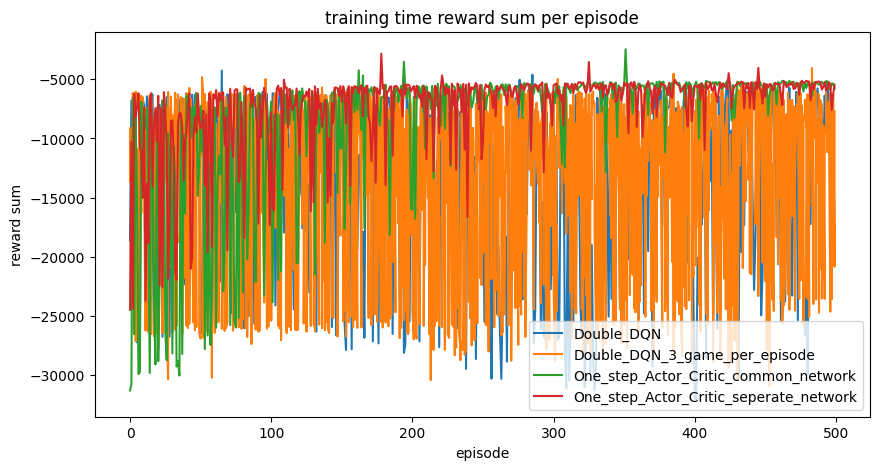

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os

logs = []
log_names = []
for file in os.listdir('logs'):
    if file.endswith('.pickle'):
        logs.append(pd.read_pickle('logs\\' + file))
        log_names.append(file)

training_dfs = []
eval_dfs = []
print(log_names)
fig, ax = plt.subplots(figsize=(10,5))
for i,log in enumerate(logs):
    training_df = pd.DataFrame(log['training'])
    training_df['action_frac'] = training_df['action_frac'].astype(str).str.strip('[]').str.split(', ')
    training_df[['left', 'right', 'no press']] = pd.DataFrame(training_df['action_frac'].to_list(), index=training_df.index).astype(float)
    if 'evaluation' in log:
        eval_df = pd.DataFrame(log['evaluation'])
    else:
        eval_df = pd.DataFrame(log['evaluating'])
    eval_df['action_frac'] = eval_df['action_frac'].astype(str).str.strip('[]').str.split(', ')
    eval_df[['left', 'right', 'no press']] = pd.DataFrame(eval_df['action_frac'].to_list(), index=eval_df.index).astype(float)
    ax.plot(training_df['episode'], training_df['reward_sum'], label=log_names[i][:-7])
    training_dfs.append(training_df)
    eval_dfs.append(eval_df)
ax.set_xlabel('episode')
ax.set_ylabel('reward sum')
ax.legend()
ax.set_title('training time')
plt.show()

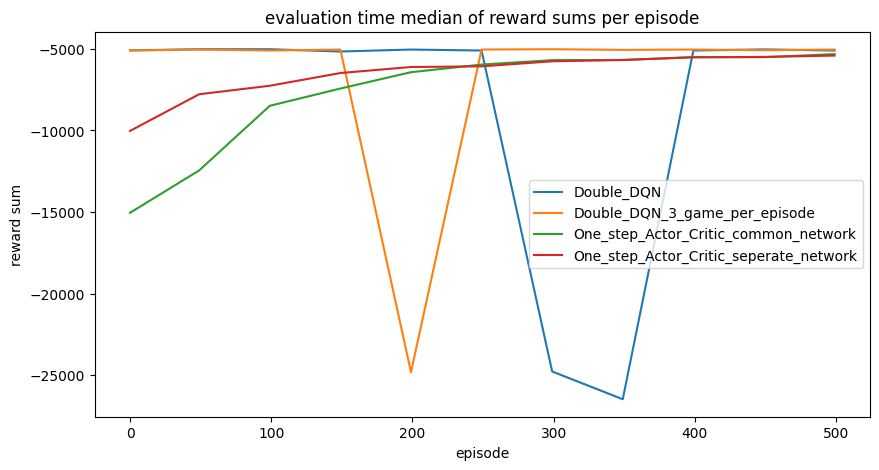

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
for i,e in enumerate(eval_dfs):
    median = e.loc[:,['reward_sum', 'episode']].groupby(['episode']).median().reset_index()
    ax.plot(median['episode'],median['reward_sum'], label=log_names[i][:-7])
ax.set_xlabel('episode')
ax.set_ylabel('reward sum')
ax.legend()
ax.set_title('evaluation time')
plt.show()

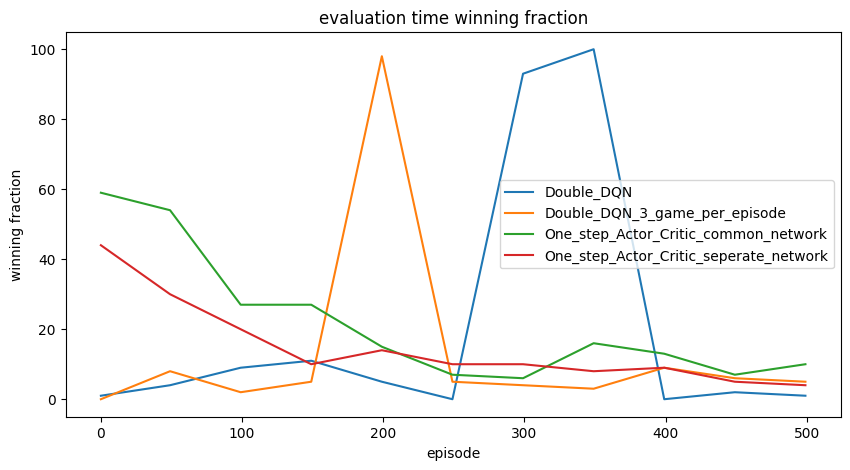

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
for i,e in enumerate(eval_dfs):
    median = e.loc[:,['result', 'episode']].groupby(['episode']).sum().reset_index()
    ax.plot(median['episode'],median['result'], label=log_names[i][:-7])
ax.set_xlabel('episode')
ax.set_ylabel('winning fraction')
ax.legend()
ax.set_title('evalluation time')
plt.show()

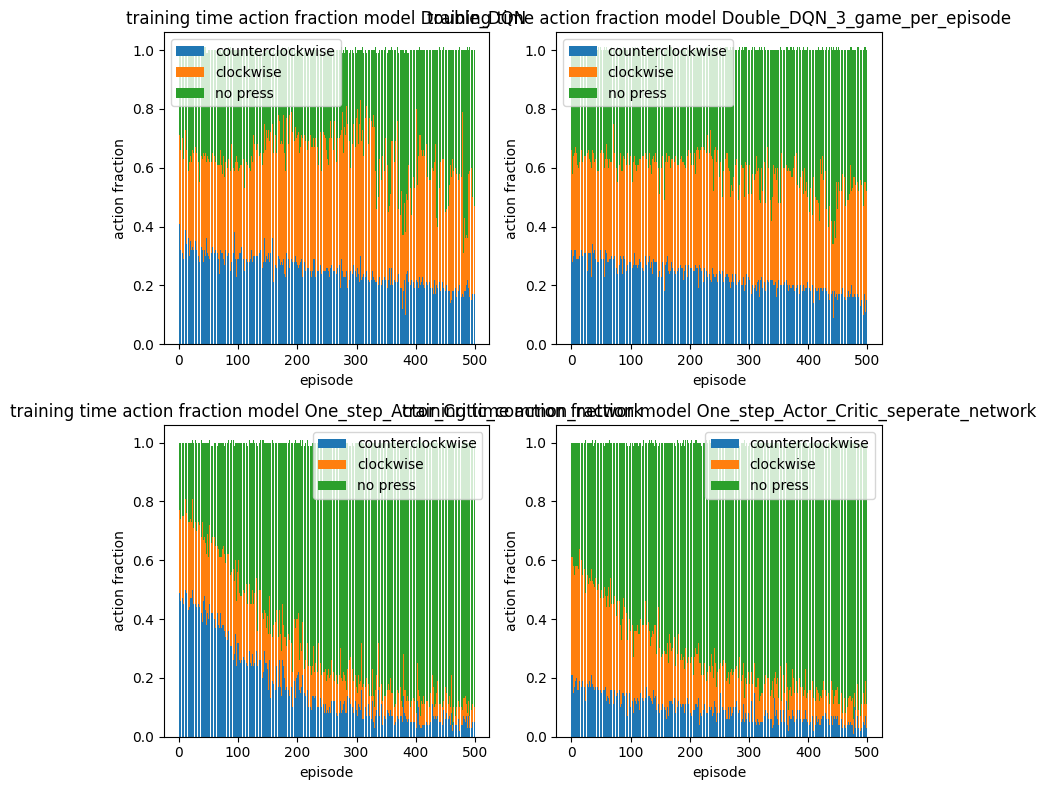

In [23]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
for i,t in enumerate(training_dfs):
    ax[i//2,i%2].bar(t['episode'], t['left'], label='counterclockwise')
    ax[i//2,i%2].bar(t['episode'], t['right'], bottom=t['left'], label='clockwise')
    ax[i//2,i%2].bar(t['episode'], t['no press'], bottom=t['left'] + t['right'], label='no press')
    ax[i//2,i%2].set_xlabel('episode')
    ax[i//2,i%2].set_ylabel('action fraction')
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_title(f'training time action fraction model {log_names[i][:-7]}')
fig.tight_layout()
plt.show()



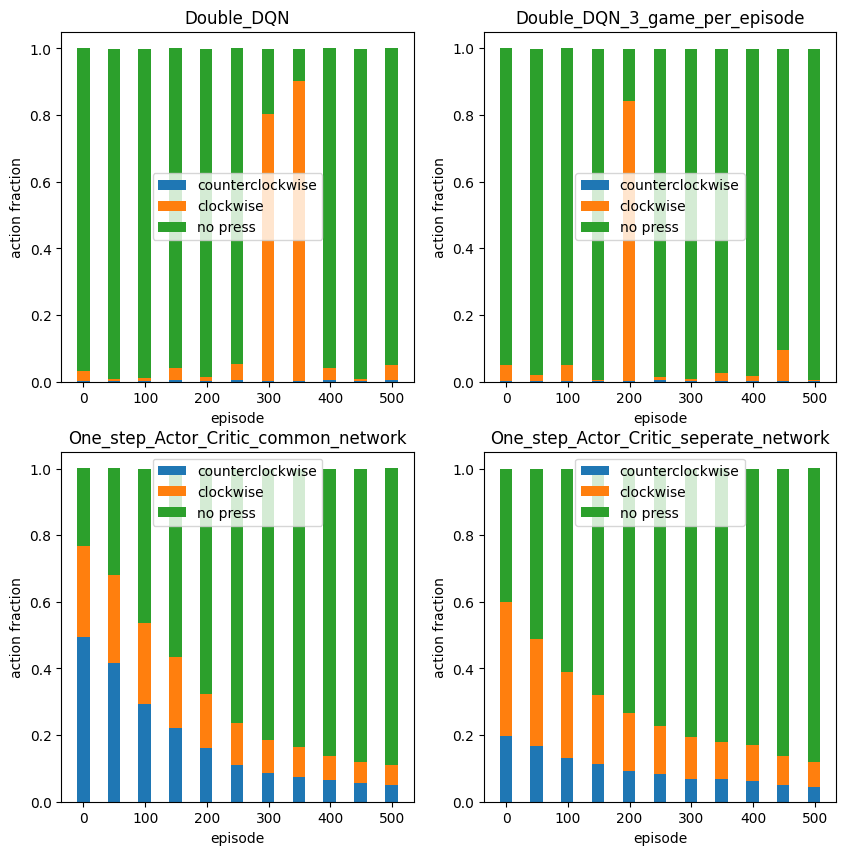

In [21]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
for i,e in enumerate(eval_dfs):
    median = e.loc[:,['left', 'right', 'no press', 'episode']].groupby(['episode']).mean().reset_index()
    ax[i//2,i%2].bar(median['episode'], median['left'], width=20, label='counterclockwise')
    ax[i//2,i%2].bar(median['episode'], median['right'], bottom=median['left'], width=20, label='clockwise')
    ax[i//2,i%2].bar(median['episode'], median['no press'], bottom=median['left'] + median['right'], width=20, label='no press')
    ax[i//2,i%2].set_xlabel('episode')
    ax[i//2,i%2].set_ylabel('action fraction')
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_title(f'{log_names[i][:-7]}')

## profiling

In [ ]:
agent.load_models('DQN_model', 200)
profiler.start()
eval_score, eval_dones, action_frac = agent.evaluate(100, agent.model)
profiler.stop()
print(profiler.output_text(unicode=True, color=True))
print('average episode score ' + str(eval_score) + ' winning fraciton ' + str(eval_dones) + ' action fraction of left, right, no press:' , [str(c) for c in action_frac])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 19:25:37  Samples:  23231
 /_//_/// /_\ / //_// / //_'/ //     Duration: 48.138    CPU time: 30.078
/   _/                      v4.6.1

Program: C:\Users\farsh\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py --f=c:\Users\farsh\AppData\Roaming\jupyter\runtime\kernel-v2-5520L223AusJMcuv.json

48.138 ZMQInteractiveShell.run_code  IPython\core\interactiveshell.py:3472
└─ 48.138 <module>  ..\AppData\Local\Temp\ipykernel_21096\748432353.py:3
   └─ 48.137 Agent.evaluate  ..\AppData\Local\Temp\ipykernel_21096\2097873893.py:39
      ├─ 17.947 DQN.forward  ..\AppData\Local\Temp\ipykernel_21096\3666422084.py:7
      │  ├─ 11.443 GRU._call_impl  torch\nn\modules\module.py:1096
      │  │     [7 frames hidden]  torch, <built-in>
      │  ├─ 2.811 pack_padded_sequence  torch\nn\utils\rnn.py:200
      │  │     [6 frames hidden]  torch, <built-in>
      │  ├─ 1.962 pad_packed_sequence  torch\nn\utils\rnn.py:253
      │  │     [3 frame